In [1]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from model_file import getModel, getList
from vit_cnn import *
from vce_dataloader import *
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
# binaryDL_train = getBinaryDataLoader(image_size=(224,224), target_class_name="Normal", path_to_dataset="/kaggle/input/vce-dataset/training",batch_size=32)
# binaryDL_val = getBinaryDataLoader(image_size=(224,224), target_class_name="Normal", path_to_dataset="/kaggle/input/vce-dataset/validation",batch_size=32)
# visualize_batch(binaryDL_train, nrow = 8)

In [4]:
# getList()

In [5]:
train_path = "/kaggle/input/vce-augmented-dataset/training/"
val_path= "/kaggle/input/vce-augmented-dataset/validation"

In [6]:
train_transform = transforms.Compose([#transforms.RandomHorizontalFlip(p=0.7),
                                     #transforms.RandomVerticalFlip(p=0.7),
                                     #transforms.RandomRotation(15),
                                     
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor()
                              ])


val_transform= transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

In [7]:
target_class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

In [8]:
finDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
finDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [9]:
len(finDL_train), len(finDL_val)

(1854, 505)

In [10]:
# visualize_batch(allDL_train, nrow=8)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# sum = 0
# for images, labels in binaryDL_train:
#     print(images.shape)  # Should print [batch_size, 1, 48, 48]
#     print(labels.shape)  # Should print [batch_size]
#     sum = sum + torch.sum(labels)
#     break
# print(sum)

In [13]:
# print(labels)

In [14]:
classifier = getModel("vitcnn")
model = classifier(cnnmodel = 'resnet34', num_classes=10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 173MB/s]


In [15]:
model

ViTCNNModel(
  (cnn_branch): CNNBranch(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

In [16]:
# model.classifier

In [17]:
# # num_ftrs = model.fc.in_features
# model.classifier[6] = nn.Linear(4096, 10)
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)

In [18]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
# model

In [20]:
num_epochs = 10

In [21]:
%%time
for epoch in range(num_epochs):
    model.train()
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    
    for i, data in enumerate(finDL_train):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if((i+1)%(len(finDL_train)//4)==0):
            print(f"{i+1}/{len(finDL_train)}: {loss.item()}")
        else: 
            print("#", end="")
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in finDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/10]
##############################################################################################################################################################################################################################################################################################################################################################################################################################################################################463/1854: 1.14568030834198
##############################################################################################################################################################################################################################################################################################################################################################################################################################################################################926/1854: 1.132021427154541
########

In [22]:
PATH = "Direct10.pt"
torch.save({
            'epoch': num_epochs-1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [23]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)  # Move images to the same device as model
            labels = labels.to(device)  # Move labels to the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    return np.array(all_preds), np.array(all_labels)

In [24]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, finDL_val)

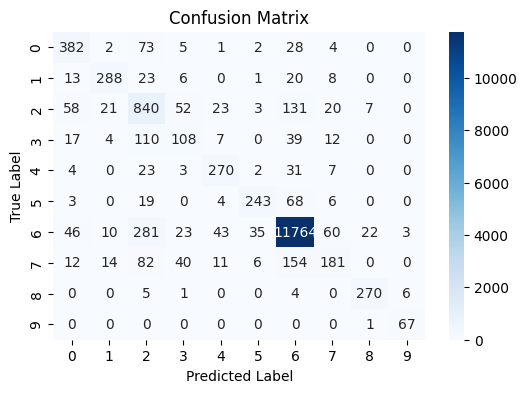

In [25]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[i for i in range(0,10)], yticklabels=[i for i in range(0,10)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# print("hi")